In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import importlib
import unicodedata
import sys

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from nltk.stem.porter import PorterStemmer

Using TensorFlow backend.


In [2]:
data = pd.read_csv('../data/sentiment140_train.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])

data = data[['text','sentiment']]

In [49]:
print(data.dtypes)

text         object
sentiment     int64
dtype: object


In [50]:
print('Positive rows: {}'.format(data[ data['sentiment'] == 4]['sentiment'].size))
print('Negative rows: {}'.format(data[ data['sentiment'] == 0]['sentiment'].size))

Positive rows: 800000
Negative rows: 800000


In [3]:
vocabulary = set()
for i, row in enumerate(data.iterrows()):
    vocabulary |= set(row[1]['text'].split())
print('The vocabulary size is', len(vocabulary))

The vocabulary size is 1350598


In [51]:
data = shuffle(data, random_state=40)

In [52]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=40)
train_data, dev_data = train_test_split(train_data, test_size=0.2, random_state=40)

In [53]:
print('train_data: ' + str(len(train_data)))
print('test_data: ' + str(len(test_data)))
print('dev_data: ' + str(len(dev_data)))

train_data: 1024000
test_data: 320000
dev_data: 256000


In [54]:
train_data.to_csv('../data/train_data.csv', index=False)
dev_data.to_csv('../data/dev_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)

In [39]:
train_data = pd.read_csv('../data/train_data.csv', encoding='ISO-8859-1', keep_default_na=False)
dev_data = pd.read_csv('../data/dev_data.csv', encoding='ISO-8859-1', keep_default_na=False)
test_data = pd.read_csv('../data/test_data.csv', encoding='ISO-8859-1', keep_default_na=False)

In [40]:
def print_df_head(df, limit=50):
    for i, row in enumerate(df.iterrows()):
        print(row[1]['sentiment'], row[1]['text'])
        if i == limit:
            break

In [41]:
print_df_head(train_data)

0 Can someone fix Twitter please??  This smell of aquatic mammals is getting a bit overpowering 
0 Just walked up the stopped 5 story escalator at peachtree center.  Who knew I'd be getting a workout on the way to class? Urban trek.
4 @AgentBooth Yes she did, there's proof. You two lovebirds are going to enjoy it 
0 @selenagomez i'm so sorry the youtube video you accidentally deleted was the dance video one   i was just about to watch it again...
0 want to go home now and come back on Thursday... 
4 Mmmm... Shamrat has arrived... 
4 going round my aunites in her pool  x
4 @stoob0t Cheers buddy, will do!  Was good seeing you last night and having a bit of a bash in the pit 
0 @thespunkyone sorry to hear that  I will come kick his ass in 20 days if you want me to! Just say the word and I will add it to my lis ...
0 I think it's time to retire the Saab. 
4 is just about to watch one tree hill 
4 @HolliWinters oh, she's a naughty, naughty girl, darling. I would call fake 
4 Good morning, S

In [42]:
# Remove twitter @ tags
def remove_twitter_at(text):
    # Get rid of the leading @
    text = re.sub('^@.*? ', '', text)
    
    # Get rid of @ in the middle of the tweet
    text = re.sub(' @.*? ', ' ', text)
    
    # Get rid of tailing @
    text = re.sub(' @.*?$', '', text)
    
    return text

In [43]:
train_data['text'] = train_data['text'].apply(remove_twitter_at)
test_data['text'] = test_data['text'].apply(remove_twitter_at)
dev_data['text'] = dev_data['text'].apply(remove_twitter_at)

In [9]:
# Create a table to map punctuations to None
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
        if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuations(text):
    return text.translate(tbl)

In [10]:
train_data['text'] = train_data['text'].apply(remove_punctuations)
test_data['text'] = test_data['text'].apply(remove_punctuations)
dev_data['text'] = dev_data['text'].apply(remove_punctuations)

In [11]:
# Only remove separate digits, not digits within word, such as `U2`
def remove_digits(text):
    # Remove leading digits
    text = re.sub('^\d+? ', ' ', text)
    
    # Remove other digits
    text = re.sub(' \d+', ' ', text)
    
    return text

In [12]:
train_data['text'] = train_data['text'].apply(remove_digits)
test_data['text'] = test_data['text'].apply(remove_digits)
dev_data['text'] = dev_data['text'].apply(remove_digits)

In [44]:
def to_lowercase(text):
    return text.lower()

In [45]:
train_data['text'] = train_data['text'].apply(to_lowercase)
test_data['text'] = test_data['text'].apply(to_lowercase)
dev_data['text'] = dev_data['text'].apply(to_lowercase)

In [15]:
# Split a string to a list of words
def split(text):
    return text.split()

In [16]:
train_data['text'] = train_data['text'].apply(split)
test_data['text'] = test_data['text'].apply(split)
dev_data['text'] = dev_data['text'].apply(split)

In [17]:
# https://www.quora.com/Is-there-a-stop-word-list-specifically-designed-for-sentiment-analysis
# As stated before, the general nltk stopwords may have a negative impacts on sentiment analysis, as it removes
# negation words such as don't. Here I build a minimal set of stopwords specific to sentiment analysis. 

stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and'
]

def remove_stopwords(arr):
    arr = [word for word in arr if word not in stopwords]
    return arr

In [18]:
train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)
dev_data['text'] = dev_data['text'].apply(remove_stopwords)

In [62]:
stemmer = PorterStemmer()

# Transform word from the derived form to root form when applicable 
def stem_words(arr):
    arr = [stemmer.stem(word) for word in arr]
    return arr

train_data['text'] = train_data['text'].apply(stem_words)
test_data['text'] = test_data['text'].apply(stem_words)
dev_data['text'] = dev_data['text'].apply(stem_words)

In [63]:
def get_corpus_vocabulary(df):
    vocabulary = Counter()
    for _, row in df.iterrows():
        words = row['text']
        for word in words:
            vocabulary[word] += 1
    return vocabulary

vocabulary = get_corpus_vocabulary(train_data)

The size of the training corpus: 332848
The top 10 words are: [(361347, 'to'), (137945, 'for'), (136893, 'in'), (117479, 'of'), (113318, 'im'), (106876, 'on'), (96571, 'so'), (88166, 'go'), (81575, 'but'), (79925, 'just')]
The least 10 words are: [(1, '$$$hip'), (1, '$$$giant'), (1, '$$$down'), (1, '$$$+'), (1, '$$$$$they'), (1, '$$$$$$fgdf^amp^^^^'), (1, '$$$$$$$$$$$$$'), (1, '$$$$$$$$$$$$'), (1, '$$$$$$$$$$$'), (1, '$$$$$$$$$$')]
[1, 1, 1, 2, 2, 3, 4, 5, 6, 6, 7, 9, 10, 11, 12, 14, 15, 17, 19, 20, 22, 24, 26, 29, 31, 34, 37, 40, 43, 46, 49, 52, 56, 60, 63, 67, 72, 76, 81, 86, 92, 97, 103, 110, 117, 124, 132, 141, 151, 161, 171, 182, 193, 206, 219, 233, 248, 264, 280, 298, 317, 338, 359, 383, 409, 437, 466, 500, 536, 577, 622, 672, 727, 788, 854, 929, 1013, 1108, 1215, 1337, 1476, 1636, 1821, 2038, 2299, 2609, 2987, 3453, 4043, 4802, 5825, 7239, 9361, 12820, 19097, 32051, 63058, 138609, 235729, 332848]


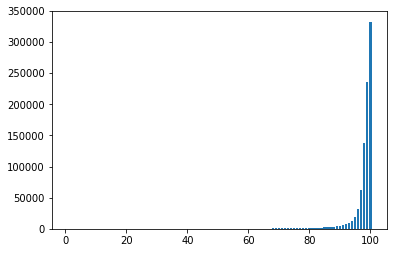

In [64]:
def show_vocabulary_summary(vocabulary):
    corpus_total_cnt = sum(vocabulary.values())
    sorted_by_wd_cnt = sorted(((cnt, wd) for wd, cnt in vocabulary.items()), reverse=True)

    plt_points = []
    accu = 0
    j = 0
    for i in range(1, 101):
        while accu < (corpus_total_cnt * i / 100.0):
            accu += sorted_by_wd_cnt[j][0]
            j += 1
        plt_points.append(j)

    print('The size of the training corpus: {}'.format(len(vocabulary)))
    print('The top 10 words are: {}'.format(sorted_by_wd_cnt[:10]))
    print('The least 10 words are: {}'.format(sorted_by_wd_cnt[-10:]))
    print(plt_points)
    plt.bar(range(1, 101), plt_points)
    
show_vocabulary_summary(vocabulary)

The top 20000 words account for 94% word occurance of the entire corpus.

In [19]:
def join(arr):
    return ' '.join(arr)

In [20]:
train_data['text'] = train_data['text'].apply(join)
test_data['text'] = test_data['text'].apply(join)
dev_data['text'] = dev_data['text'].apply(join)

In [46]:
print_df_head(train_data)

0 can someone fix twitter please??  this smell of aquatic mammals is getting a bit overpowering 
0 just walked up the stopped 5 story escalator at peachtree center.  who knew i'd be getting a workout on the way to class? urban trek.
4 yes she did, there's proof. you two lovebirds are going to enjoy it 
0 i'm so sorry the youtube video you accidentally deleted was the dance video one   i was just about to watch it again...
0 want to go home now and come back on thursday... 
4 mmmm... shamrat has arrived... 
4 going round my aunites in her pool  x
4 cheers buddy, will do!  was good seeing you last night and having a bit of a bash in the pit 
0 sorry to hear that  i will come kick his ass in 20 days if you want me to! just say the word and i will add it to my lis ...
0 i think it's time to retire the saab. 
4 is just about to watch one tree hill 
4 oh, she's a naughty, naughty girl, darling. i would call fake 
4 good morning, sweet people! 
4 last day of school... teachers of lcs rejoice!

In [32]:
print('train_data:')
print(train_data['sentiment'].unique())
print('test_data:')
print(test_data['sentiment'].unique())
print('dev_data:')
print(dev_data['sentiment'].unique())

train_data:
[0 4]
test_data:
[4 0]
dev_data:
[0 4]


In [33]:
def replace_nan_by_empty_str(text):
    if text == np.nan:
        return ''
    else:
        return text

In [34]:
train_data['text'] = train_data['text'].apply(replace_nan_by_empty_str)
test_data['text'] = test_data['text'].apply(replace_nan_by_empty_str)
dev_data['text'] = dev_data['text'].apply(replace_nan_by_empty_str)

In [35]:
print('train_data: ' + str(len(train_data)))
print('dev_data: ' + str(len(dev_data)))
print('test_data: ' + str(len(test_data)))

train_data: 1024000
dev_data: 256000
test_data: 320000


In [76]:
train_data.to_csv('../data/fully_cleansed_train_data.csv', index=False)
dev_data.to_csv('../data/fully_cleansed_dev_data.csv', index=False)
test_data.to_csv('../data/fully_cleansed_test_data.csv', index=False)

In [26]:
train_data.to_csv('../data/no_stemming_train_data.csv', index=False)
dev_data.to_csv('../data/no_stemming_dev_data.csv', index=False)
test_data.to_csv('../data/no_stemming_test_data.csv', index=False)

In [36]:
train_data.to_csv('../data/no_tags_train_data.csv', index=False)
dev_data.to_csv('../data/no_tags_dev_data.csv', index=False)
test_data.to_csv('../data/no_tags_test_data.csv', index=False)

In [47]:
train_data.to_csv('../data/no_tags_lower_train_data.csv', index=False)
dev_data.to_csv('../data/no_tags_lower_dev_data.csv', index=False)
test_data.to_csv('../data/no_tags_lower_test_data.csv', index=False)